<h1>Visualizing Convnets with Tensorflow</h1>

We start with importing our dependencies including the imFuctions which I made myself.

In [1]:
import imFunctions as imf
import tensorflow as tf
import scipy.ndimage
from scipy.misc import imsave
import matplotlib.pyplot as plt
import numpy as np

These functions will download and extract the dataset for you.

In [2]:
imf.downloadImages('annotations.tar.gz', 19173078)
imf.downloadImages('images.tar.gz', 791918971)
imf.maybeExtract('annotations.tar.gz')
imf.maybeExtract('images.tar.gz')

File 'annotations.tar.gz' allready downloaded :)
File 'images.tar.gz' allready downloaded :)
annotations already present - Skipping extraction of annotations.tar.gz
images already present - Skipping extraction of images.tar.gz


Here you can decide what percentage of your data you would like to use as test data.

In [3]:
imf.sortImages(0.15)

Images allready sorted


This function will build all your training data into numpy arrays and print out your classes associated one hot vector.  This will also subtract the mean value of your train data from both the test and train data, this is a standard practice in building convnets.

In [4]:
train_x, train_y, test_x, test_y, classes, classLabels = imf.buildDataset()

Do you want to use englishcockerspaniel in your dataset?  [y/n/break]
Do you want to use EgyptianMau in your dataset?  [y/n/break]
Do you want to use greatpyrenees in your dataset?  [y/n/break]
Do you want to use Sphynx in your dataset?  [y/n/break]
Do you want to use Birman in your dataset?  [y/n/break]
Do you want to use shibainu in your dataset?  [y/n/break]y
Do you want to use staffordshirebullterrier in your dataset?  [y/n/break]
Do you want to use RussianBlue in your dataset?  [y/n/break]
Do you want to use samoyed in your dataset?  [y/n/break]y
Do you want to use japanesechin in your dataset?  [y/n/break]break
shibainu = [[ 1.  0.]]
samoyed = [[ 0.  1.]]
Total Train Size: 340  Total Test Size: 60  Total # Classes 2


Let's just load one image to mess around with in the future.

In [5]:
image = train_x[202]
scipy.misc.imshow(image)

Before jumping into a color convolutional filter let's look at a grayscale one to make sure everything is clear. Let's make a 7x7 filter that applies four different effects.  

TensorFlow explains the conv2d kernel as:

a filter / kernel tensor of shape [filter_height, filter_width, in_channels, out_channels]</i>

https://www.tensorflow.org/api_docs/python/tf/nn/conv2d

Since we are working with grayscale our in_channels will be 1 and since we are applying three filters our out channel will be 4.

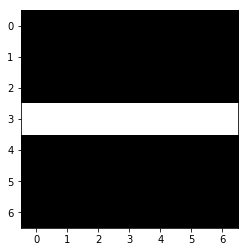

In [6]:
filters = np.zeros([7,7,1,4])

filters[3,:,0,0] = 1
plt.imshow(filters[:,:,:,0].reshape(7,7), cmap='gray')
plt.show()

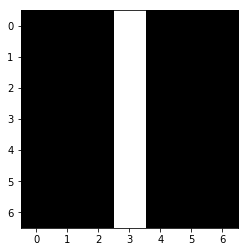

In [7]:
filters[:,3,0,1] = 1
plt.imshow(filters[:,:,:,1].reshape(7,7), cmap='gray')
plt.show()

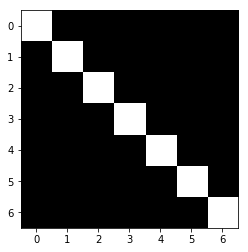

In [8]:
filters[:,:,0,2] = np.eye(7,7)
plt.imshow(filters[:,:,:,2].reshape(7,7), cmap='gray')
plt.show()

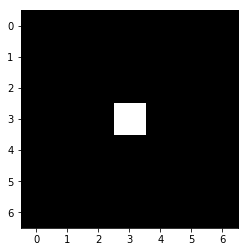

In [9]:
filters[:,:,:,3] -= 1
filters[3,3,:,3] = 8
plt.imshow(filters[:,:,:,3].reshape(7,7), cmap='gray')
plt.show()

Next let's convert our image to grayscale.  We then slide our kernel over the image with a padding around the border to apply our filter and maintain our images shape.  This website (http://setosa.io/ev/image-kernels/) does a excellent job of visualizing this process.  Notice we have to convert our image into a 4d tensor.

In [10]:
gray = np.mean(image,-1)
X = tf.placeholder(tf.float32, shape=(None, 224, 224, 1))
conv = tf.nn.conv2d(X, filters, [1,1,1,1], padding="SAME")
test = tf.Session()
test.run(tf.global_variables_initializer())
filteredImage = test.run(conv, feed_dict={X: gray.reshape(1,224,224,1)})
tf.reset_default_graph()

This will return a 4d tensor of (1, 224, 224, 4). We can reset the TensorFlow graph since we wont be using this node again.


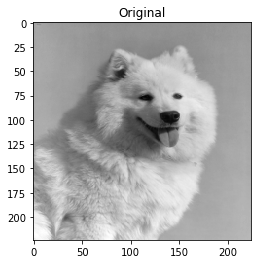

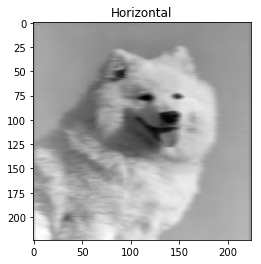

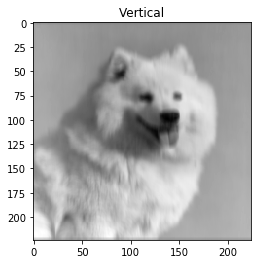

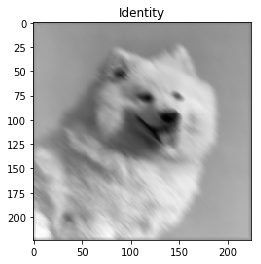

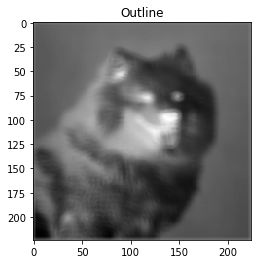

In [11]:
plt.imshow(gray, cmap='gray')
plt.title('Original')
plt.show()
labels = ['Horizontal', 'Vertical', 'Identity', 'Outline']
for i in range(4):
    plt.title(labels[i])
    plt.imshow(filteredImage[:,:,:,i].reshape(224,224),cmap = 'gray')
    plt.show()

It's clear to see that convolutions of filter kernels can drastically change an image. 

Now in essence most convolutional neural networks consist of just convolutions and poolings.  Particularly max poolings with a stride of 2 and kernel size of 4 are just an aggressive way to essentially reduce a image size based upon it’s maximum pixel values within a kernel.  Here is a basic example of a 2x2 kernel with a stride of two in both dimensions.  

<img src="imageFiles/pool.gif">

There is also two options to choose for padding “VALID” which will shrink an input and “SAME” which will maintain the input image size by adding zeros around the edges of the input.  Here is an example of a max pool with a 3x3 kernel with a stride of 1x1 to compare the padding options:

<img src="imageFiles/pool2.gif">

So now that we got the basics let’s start building our convolutional neural network model.  We can start with our placeholders. X will be our input placeholder which we will feed our images into and Y_ will be the true classes of a set of images.  We will also define keepRate which we will later use for dropout.

In [12]:
X = tf.placeholder(tf.float32, shape=(None, 224, 224, 3))
Y_ = tf.placeholder(tf.float32, [None, classes])
keepRate1 = tf.placeholder(tf.float32)
keepRate2 = tf.placeholder(tf.float32)

For a model we will use a very simple 4 convolutional neural network shown below:


<img src="imageFiles/convnet2.png">

We will create all parts of the first convolution under one scope, this will be extremely useful for when visualizing the graph in Tensorboard down the road. It will group everything into one expandable object.  We create our first set of filters which takes in 3 channels and outputs 32.  It’s very important that the weight values for our filter are initialized using truncated normal so that we have multiple random filters in which our Tensorflow will adapt to fit our model.

In [13]:
# CONVOLUTION 1 - 1
with tf.name_scope('conv1_1'):
    filter1_1 = tf.Variable(tf.truncated_normal([3, 3, 3, 32], dtype=tf.float32,
                            stddev=1e-1), name='weights1_1')
    stride = [1,1,1,1]
    conv = tf.nn.conv2d(X, filter1_1, stride, padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[32], dtype=tf.float32),
                         trainable=True, name='biases1_1')
    out = tf.nn.bias_add(conv, biases)
    conv1_1 = tf.nn.relu(out)

If we want to visualize our initial filters we can do so by running our image through the conv1_1 node.

In [14]:
# Un-comment below if you want to visualize

#test.run(tf.global_variables_initializer())
#filteredImage = test.run(conv1_1, feed_dict={X: image.reshape(1,224,224,3)})
#for i in range(32):
#    plt.imshow(filteredImage[:,:,:,i].reshape(224,224))
#    plt.show()

You can see the the random initialized weights are allready beginnnig to act like a pretty good edge detector.

Continuing on to the next convolution we convolve those 32 features together into another 32 features.  You can see conv2d assigns the input to be the output of the first convolutional layer.

In [15]:
# CONVOLUTION 1 - 2
with tf.name_scope('conv1_2'):
    filter1_2 = tf.Variable(tf.truncated_normal([3, 3, 32, 32], dtype=tf.float32,
                                                stddev=1e-1), name='weights1_2')
    conv = tf.nn.conv2d(conv1_1, filter1_2, [1,1,1,1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[32], dtype=tf.float32),
                         trainable=True, name='biases1_2')
    out = tf.nn.bias_add(conv, biases)
    conv1_2 = tf.nn.relu(out)

We then pool to shrink the image in half.

In [16]:
# POOL 1
with tf.name_scope('pool1'):
    pool1_1 = tf.nn.max_pool(conv1_2,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME',
                             name='pool1_1')
    pool1_1_drop = tf.nn.dropout(pool1_1, keepRate1)

This last part applies drop on the pool layer which we will use during trainging.  We then follow with two more convolutions with 64 features and another pool.  Notice that the first convolution has to convert the previous 32 feature channels into 64.

In [17]:
# CONVOLUTION 2 - 1
with tf.name_scope('conv2_1'):
    filter2_1 = tf.Variable(tf.truncated_normal([3, 3, 32, 64], dtype=tf.float32,
                                                stddev=1e-1), name='weights2_1')
    conv = tf.nn.conv2d(pool1_1_drop, filter2_1, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                         trainable=True, name='biases2_1')
    out = tf.nn.bias_add(conv, biases)
    conv2_1 = tf.nn.relu(out)
    
# CONVOLUTION 2 - 2
with tf.name_scope('conv2_2'):
    filter2_2 = tf.Variable(tf.truncated_normal([3, 3, 64, 64], dtype=tf.float32,
                                                stddev=1e-1), name='weights2_2')
    conv = tf.nn.conv2d(conv2_1, filter2_2, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                         trainable=True, name='biases2_2')
    out = tf.nn.bias_add(conv, biases)
    conv2_2 = tf.nn.relu(out)
    
# POOL 2
with tf.name_scope('pool2'):
    pool2_1 = tf.nn.max_pool(conv2_2,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME',
                             name='pool2_1')
    pool2_1_drop = tf.nn.dropout(pool2_1, keepRate1)


Let's take a peak at what the final convolutional layer looks like

In [18]:
# Un-comment below if you want to visualize

#test.run(tf.global_variables_initializer())
#filteredImage = test.run(conv2_2, feed_dict={X: image.reshape(1,224,224,3), keepRate1: 1})
#for i in range(64):
#    plt.imshow(filteredImage[:,:,:,i].reshape(112,112))
#    plt.show()

We then create a 512 neuron fully connected layer which will have a weight connection for each pixel of our 56x56x64 pool2 layer.  That’s over 100 million different weight values!  In order to calculate our fully connected network we have to flatten the input into 1 dimension then we can multiply it by our weights and add our bias.

In [19]:
#FULLY CONNECTED 1
with tf.name_scope('fc1') as scope:
    shape = int(np.prod(pool2_1_drop.get_shape()[1:]))
    fc1w = tf.Variable(tf.truncated_normal([shape, 512], dtype=tf.float32,
                                           stddev=1e-1), name='weights3_1')
    fc1b = tf.Variable(tf.constant(1.0, shape=[512], dtype=tf.float32),
                       trainable=True, name='biases3_1')
    pool2_flat = tf.reshape(pool2_1_drop, [-1, shape])
    out = tf.nn.bias_add(tf.matmul(pool2_flat, fc1w), fc1b)
    fc1 = tf.nn.relu(out)
    fc1_drop = tf.nn.dropout(fc1, keepRate2)

Lastly we have our softmax with its associated weights and bias and finally our output Y.

In [20]:
#FULLY CONNECTED 3 & SOFTMAX OUTPUT
with tf.name_scope('softmax') as scope:
    fc2w = tf.Variable(tf.truncated_normal([512, classes], dtype=tf.float32,
                                           stddev=1e-1), name='weights3_2')
    fc2b = tf.Variable(tf.constant(1.0, shape=[classes], dtype=tf.float32),
                       trainable=True, name='biases3_2')
    Ylogits = tf.nn.bias_add(tf.matmul(fc1_drop, fc2w), fc2b)
    Y = tf.nn.softmax(Ylogits)

Now we can start developing the training aspect of our model.  First we have to decide the batch size; I couldn’t use more than ten without running out of memory.  Then we have to decide the number of epochs which is the number of times the algorithm will cycle through all the training data in batches, and lastly our learning rate alpha.

In [21]:
numEpochs = 400
batchSize = 10
alpha = 1e-5

When then create some scopes for our cross entropy, accuracy checker, and back propagation optimizer.

In [22]:
with tf.name_scope('cross_entropy'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_)
    loss = tf.reduce_mean(cross_entropy)

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate=alpha).minimize(loss)


We can then create our session and initialize all our variables.

In [23]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

Now we also will want to utilize TensorBoard so that we can visualize how well or classifier is doing.  We will create two plots one for our training set and one for our test set.  We can visualize our graph network by using the add_graph function.  We will measure our total loss and accuracy using summary scalar, and merge our summaries together so that we only have to call one variable to log our scalars.

In [24]:
writer_1 = tf.summary.FileWriter("/tmp/cnn/train")
writer_2 = tf.summary.FileWriter("/tmp/cnn/test")
writer_1.add_graph(sess.graph)
tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
tf.summary.histogram("weights1_1", filter1_1)
write_op = tf.summary.merge_all()

We then can set up our code for evaluation and training.  We don’t want to use our summary writer for our loss and accuracy for every time step for this we greatly slow down the classifier, so instead we log every 5 steps.

In [25]:
steps = int(train_x.shape[0]/batchSize)

for i in range(numEpochs):
    accHist = []
    accHist2 = []
    train_x, train_y = imf.shuffle(train_x, train_y)
    for ii in range(steps):
        #Calculate our current step
        step = i * steps + ii
        #Feed forward batch of train images into graph and log accuracy
        acc = sess.run([accuracy], feed_dict={X: train_x[(ii*batchSize):((ii+1)*batchSize),:,:,:], Y_: train_y[(ii*batchSize):((ii+1)*batchSize)], keepRate1: 1, keepRate2: 1})
        accHist.append(acc)
        
        if step % 5 == 0:
            # Get Train Summary for one batch and add summary to TensorBoard
            summary = sess.run(write_op, feed_dict={X: train_x[(ii*batchSize):((ii+1)*batchSize),:,:,:], Y_: train_y[(ii*batchSize):((ii+1)*batchSize)], keepRate1: 1, keepRate2: 1})
            writer_1.add_summary(summary, step)
            writer_1.flush()
            
            # Get Test Summary on random 10 test images and add summary to TensorBoard
            test_x, test_y = imf.shuffle(test_x, test_y)
            summary = sess.run(write_op, feed_dict={X: test_x[0:10,:,:,:], Y_: test_y[0:10], keepRate1: 1, keepRate2: 1})
            writer_2.add_summary(summary, step)
            writer_2.flush()

        #Back propigate using adam optimizer to update weights and biases.
        sess.run(train_step, feed_dict={X: train_x[(ii*batchSize):((ii+1)*batchSize),:,:,:], Y_: train_y[(ii*batchSize):((ii+1)*batchSize)], keepRate1: 0.2, keepRate2: 0.5})
    
    print('Epoch number {} Training Accuracy: {}'.format(i+1, np.mean(accHist)))
    
    #Feed forward all test images into graph and log accuracy
    for iii in range(int(test_x.shape[0]/batchSize)):
        acc = sess.run(accuracy, feed_dict={X: test_x[(iii*batchSize):((iii+1)*batchSize),:,:,:], Y_: test_y[(iii*batchSize):((iii+1)*batchSize)], keepRate1: 1, keepRate2: 1})
        accHist2.append(acc)
    print("Test Set Accuracy: {}".format(np.mean(accHist2)))
    
    
        

Epoch number 1 Training Accuracy: 0.5235294699668884
Test Set Accuracy: 0.4000000059604645
Epoch number 2 Training Accuracy: 0.5117647051811218
Test Set Accuracy: 0.416666716337204
Epoch number 3 Training Accuracy: 0.5235294103622437
Test Set Accuracy: 0.4166666567325592
Epoch number 4 Training Accuracy: 0.5264706015586853
Test Set Accuracy: 0.4000000059604645
Epoch number 390 Training Accuracy: 0.9088234901428223
Test Set Accuracy: 0.8499999642372131
Epoch number 391 Training Accuracy: 0.8970588445663452
Test Set Accuracy: 0.8499999046325684
Epoch number 392 Training Accuracy: 0.8970587849617004
Test Set Accuracy: 0.8499999642372131
Epoch number 393 Training Accuracy: 0.8911764621734619
Test Set Accuracy: 0.8500000834465027
Epoch number 394 Training Accuracy: 0.8970587849617004
Test Set Accuracy: 0.8500000834465027
Epoch number 395 Training Accuracy: 0.8970587849617004
Test Set Accuracy: 0.8500000834465027
Epoch number 396 Training Accuracy: 0.8970587849617004
Test Set Accuracy: 0.850

As this is training let’s check out the tensorboard results by activating tensorboard in the terminal.

tensorboard --logdir="/tmp/cnn/"

And navigate to: http://0.0.0.0:6006

As you can see by using scopes we are able to visualize a nice clean version of our graph.


<img src="imageFiles/graph.png">

For extra fun for every 50 training steps I passed an image through a filter and made a gif of the filters weights evolving.  It resulted in some pretty cool effects and some really good insight on how the convolutional network was working.  Here is two filters from conv1_2.

<img src="imageFiles/conv1.gif">

You can see the initial weight initialization show a lot of the image but as the weights updated over time they became more focused on detecting certain edges.  To my surprise I discovered that the very first convolutional kernel filter1_1 hardly changed at all.  It seemed that the beginning weight initializations did good enough on their own.  Going further down the network here is conv2_2, you can see it beginning to detect more abstract generalized features.

<img src="imageFiles/conv2.gif">

So all in all I was extremely impressed that I was able to train a model with almost 90% accuracy using less than 400 training images.  I’m sure with more training data and more tweaking of the hyper parameters I could of achieved even better results.  This concludes how to create a convolutional neural network from scratch using TensorFlow and how to gain inferences from both TensorBoard and by visualizing our filters.  It’s important to remember that often what people will do is take a model and weights that have already been trained on a huge dataset with multiple gpus such as GoogLeNet or VGG16 and cut off the very last layer and replace them with their own classes.  Then all the classifier has to do is learn the weights for the very last layer and use the pre existing trained filter weights.

In [26]:
sess.close()